In [ ]:
pip install pandas yfinance matplotlib

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

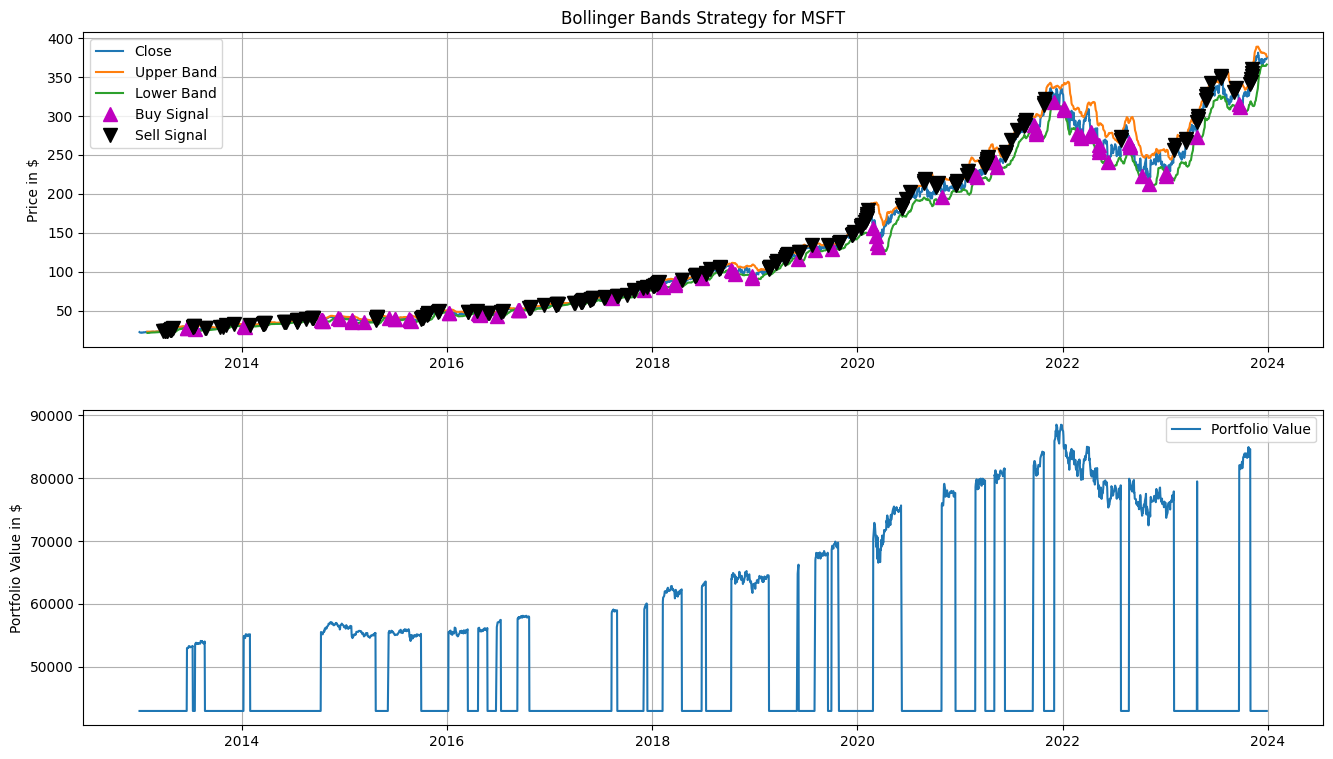

Performance metrics for MSFT:
  Capital Used: $600,884.74
  Return: $32,945.06, 329.45%
  Annual Return: 0.14
  Annual Volatility: 1.07




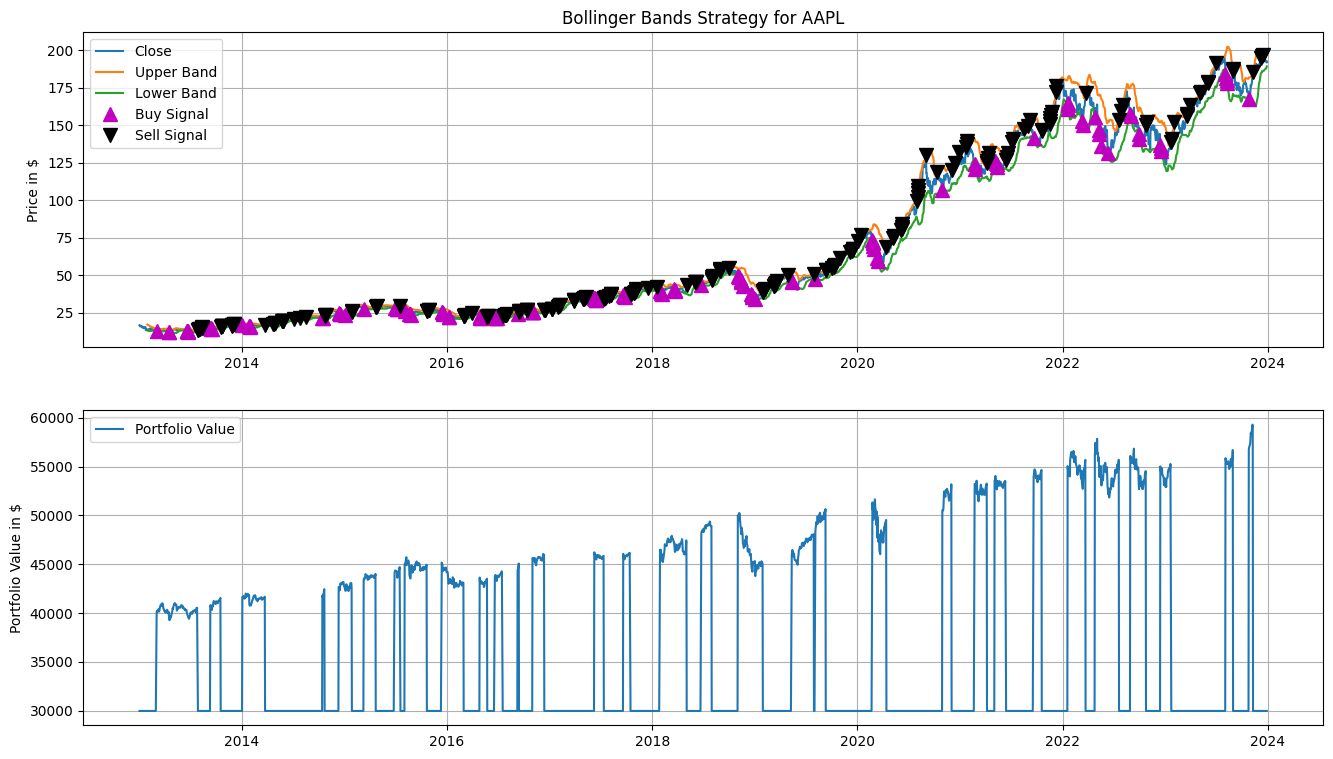

Performance metrics for AAPL:
  Capital Used: $561,647.20
  Return: $19,978.61, 199.79%
  Annual Return: 0.11
  Annual Volatility: 1.23




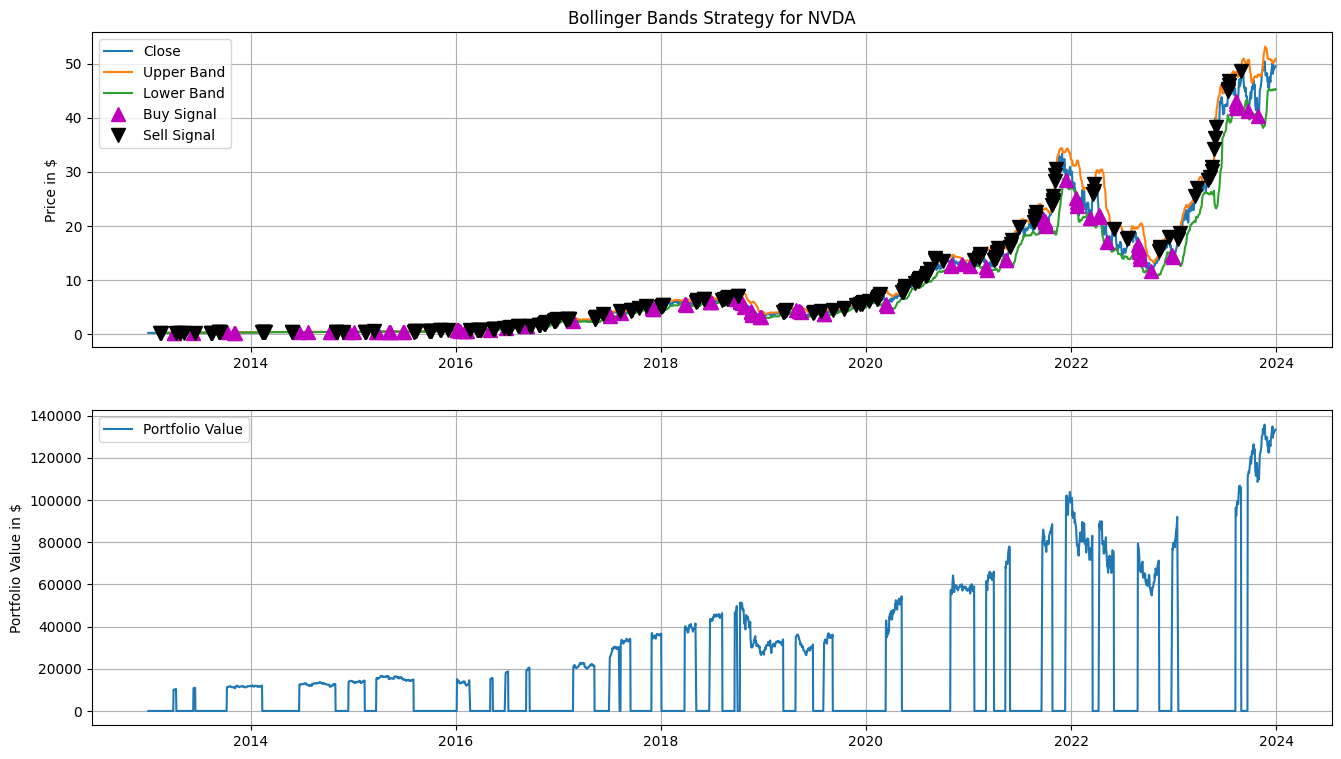

Performance metrics for NVDA:
  Capital Used: $1,352,637.74
  Return: $123,418.67, 1234.19%
  Annual Return: 0.27
  Annual Volatility: 3730.45




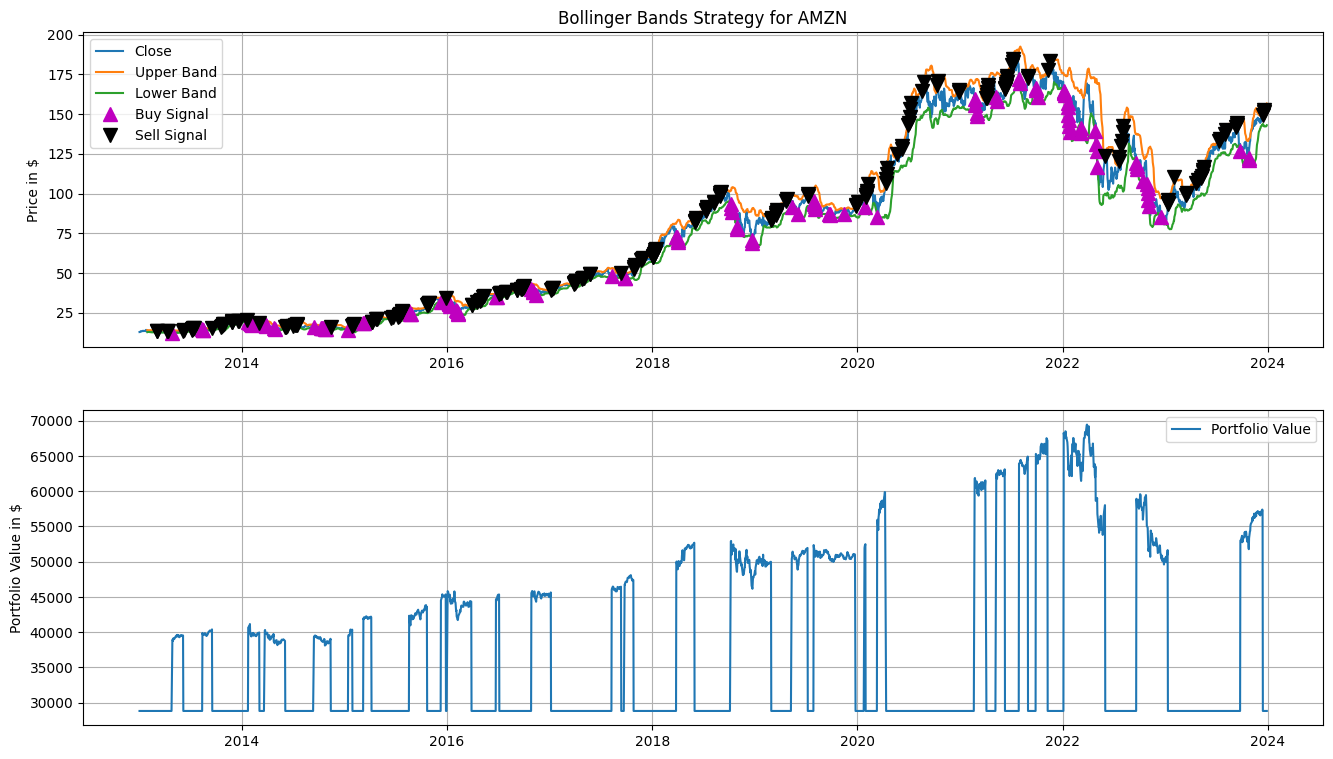

Performance metrics for AMZN:
  Capital Used: $562,861.24
  Return: $18,821.30, 188.21%
  Annual Return: 0.10
  Annual Volatility: 1.39




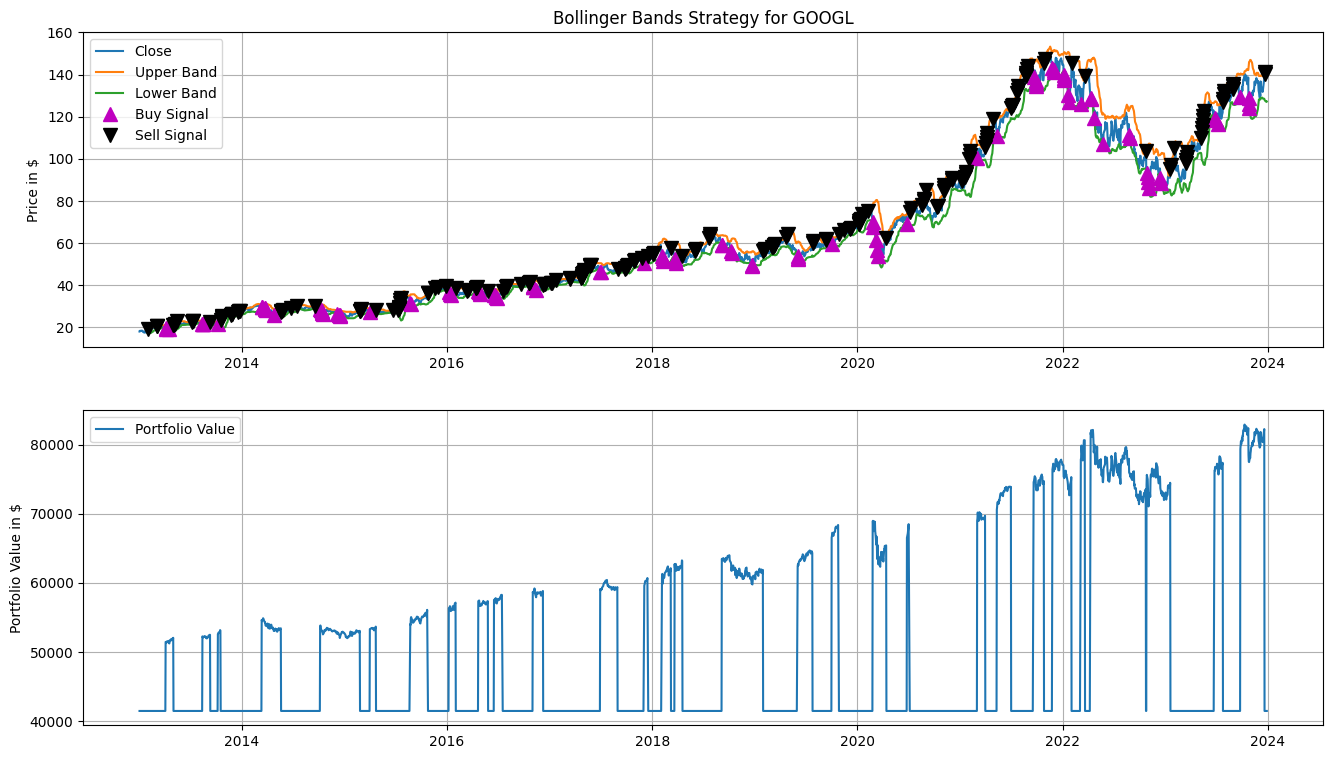

Performance metrics for GOOGL:
  Capital Used: $649,176.01
  Return: $31,467.00, 314.67%
  Annual Return: 0.14
  Annual Volatility: 1.11




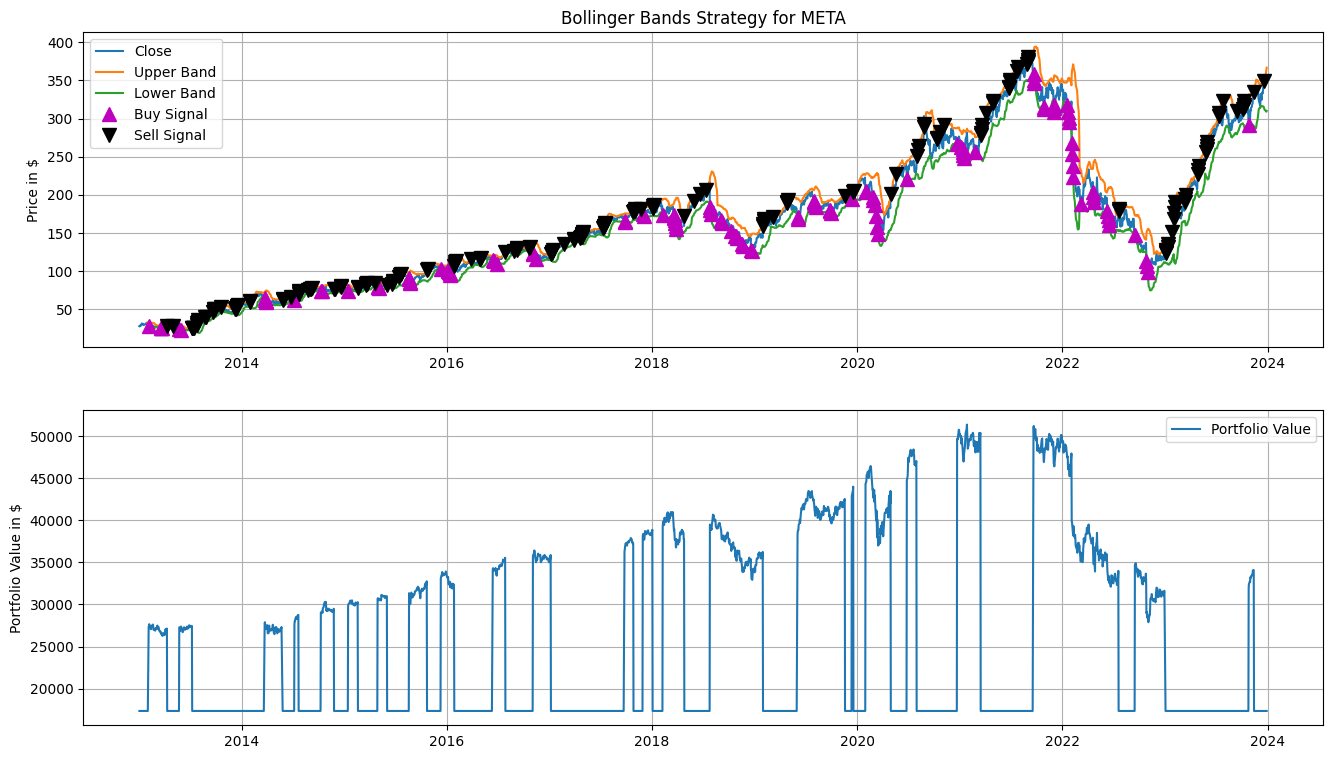

Performance metrics for META:
  Capital Used: $426,324.59
  Return: $7,336.75, 73.37%
  Annual Return: 0.05
  Annual Volatility: 1.81




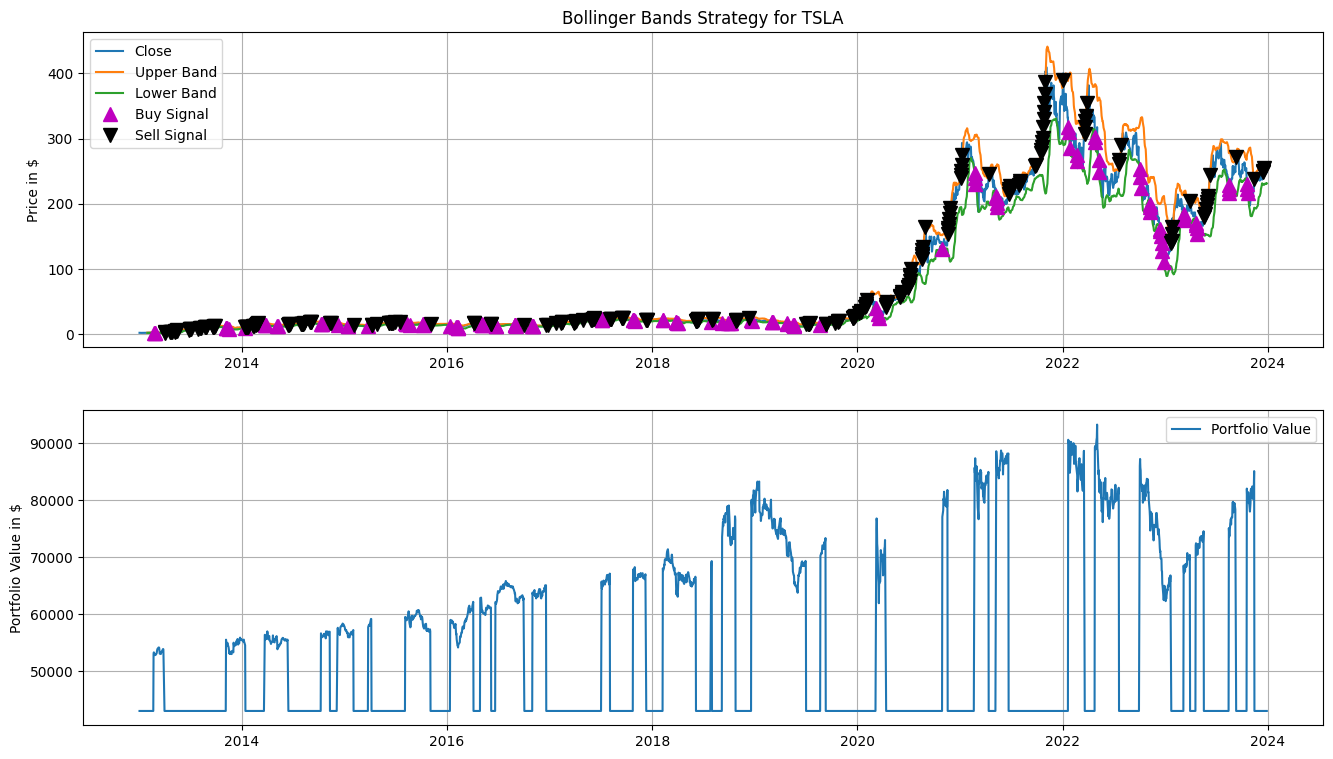

Performance metrics for TSLA:
  Capital Used: $778,228.75
  Return: $33,053.40, 330.53%
  Annual Return: 0.14
  Annual Volatility: 1.26



Overall Performance:
  Total Return: $267,020.80
  Annual Return: 0.95
  Annual Volatility: 3738.32
  Sharpe Ratio: 4.65
  Sortino Ratio: 1454.42
  Maximum Drawdown: -4.29


In [28]:
# Define tickers and parameters
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA']
initial_capital = 10000
min_transaction_size = 1

# Historical data
def get_data(tickers, start_date='2013-01-01', end_date='2023-12-31'):
    data = {}
    for ticker in tickers:
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(start=start_date, end=end_date)
        data[ticker] = tickerDf
    return data

# Signals
def generate_signals(tickerDf):
    # Calculate Bollinger Bands
    tickerDf['20 Day MA'] = tickerDf['Close'].rolling(window=20).mean()
    tickerDf['20 Day STD'] = tickerDf['Close'].rolling(window=20).std()
    tickerDf['Upper Band'] = tickerDf['20 Day MA'] + (tickerDf['20 Day STD'] * 2)
    tickerDf['Lower Band'] = tickerDf['20 Day MA'] - (tickerDf['20 Day STD'] * 2)

    # Generate Buy and Sell signals
    tickerDf['Buy_Signal'] = (tickerDf['Close'] < tickerDf['Lower Band']).astype(int)
    tickerDf['Sell_Signal'] = (tickerDf['Close'] > tickerDf['Upper Band']).astype(int)
    
    return tickerDf

# Simulate trading! :)
# Positions and Holdings: track the no. of shares held and their value
# Buy: if buy signal and enough cash, buy shares, update cash and capital used
# Sell: if sell signal and enough shares, sell shares and update cash
def simulate_trading(data):
    # Initialise DataFrames
    positions = pd.DataFrame(index=data.index, columns=['Holdings'], dtype=float).fillna(0.0)
    holdings = pd.DataFrame(index=data.index, columns=['Holdings'], dtype=float).fillna(0.0)
    
    cash = initial_capital
    shares = 0
    capital_used = 0

    for i in range(len(data)):
        current_price = data['Close'].iloc[i]
        
        if data['Buy_Signal'].iloc[i] == 1 and cash >= current_price:
            # Calculate no. of shares to buy
            buy_amount = cash // current_price
            if buy_amount > 0:
                shares += buy_amount
                cash -= buy_amount * current_price
                capital_used += buy_amount * current_price
        
        elif data['Sell_Signal'].iloc[i] == 1 and shares > 0:
            # Calculate no. of shares to sell
            sell_amount = shares
            if sell_amount > 0:
                shares -= sell_amount
                cash += sell_amount * current_price
        
        holdings.iloc[i] = shares * current_price
        positions.iloc[i] = shares
    
    # Calculate portfolio value
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Cash'] = cash
    portfolio['Holdings'] = holdings
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']
    portfolio['Returns'] = portfolio['Total'].pct_change().fillna(0)
    
    return portfolio, capital_used

# Plot results
def plot_results(tickerDf, portfolio, ticker):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))

    # Bollinger Bands Strategy
    for c in ['Close', 'Upper Band', 'Lower Band']:
        ax1.plot(tickerDf.index, tickerDf[c], label=c)
    ax1.plot(tickerDf.loc[tickerDf['Buy_Signal'] == 1].index, tickerDf.loc[tickerDf['Buy_Signal'] == 1]['Lower Band'], '^', markersize=10, color='m', label='Buy Signal')
    ax1.plot(tickerDf.loc[tickerDf['Sell_Signal'] == 1].index, tickerDf.loc[tickerDf['Sell_Signal'] == 1]['Upper Band'], 'v', markersize=10, color='k', label='Sell Signal')
    ax1.set_ylabel('Price in $')
    ax1.set_title(f'Bollinger Bands Strategy for {ticker}')
    ax1.legend(loc='best')
    ax1.grid()

    # Portfolio Value
    ax2.plot(portfolio.index, portfolio['Total'], label='Portfolio Value')
    ax2.set_ylabel('Portfolio Value in $')
    ax2.legend(loc='best')
    ax2.grid()
    
    plt.show()

# Performance metrics
def calculate_performance(portfolio, capital_used):
    # Total Return
    final_cash = portfolio['Cash'].iloc[-1]
    total_holdings_value = portfolio['Holdings'].iloc[-1]
    final_value = final_cash + total_holdings_value
    total_return_amount = final_value - initial_capital
    total_return_percentage = (total_return_amount / initial_capital) * 100
    
    # Annual Return
    num_years = (portfolio.index[-1] - portfolio.index[0]).days / 365.25
    annual_return = (final_value / initial_capital) ** (1 / num_years) - 1
    
    # Annual Volatility
    returns = portfolio['Returns']
    annual_volatility = returns.std() * np.sqrt(252)  # 252 trading days in a year
    
    # Sharpe Ratio
    risk_free_rate = 0.0  # Assume 0% risk-free rate
    sharpe_ratio = (returns.mean() * 252 - risk_free_rate) / annual_volatility
    
    # Sortino Ratio
    downside_returns = returns[returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (returns.mean() * 252 - risk_free_rate) / downside_volatility
    
    # Maximum Drawdown
    rolling_max = portfolio['Total'].cummax()
    drawdowns = (portfolio['Total'] - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    return capital_used, total_return_amount, total_return_percentage, annual_return, annual_volatility, sharpe_ratio, sortino_ratio, max_drawdown

def main():
    data = get_data(tickers)
    
    overall_capital_used = 0
    overall_total_return_amount = 0
    overall_total_return_percentage = 0
    overall_annual_return = 0
    overall_annual_volatility = 0
    overall_sharpe_ratio = 0
    overall_sortino_ratio = 0
    overall_max_drawdown = 0
    
    for ticker in tickers:
        tickerDf = generate_signals(data[ticker])
        portfolio, capital_used = simulate_trading(tickerDf)
        plot_results(tickerDf, portfolio, ticker)
        
        (capital_used, total_return_amount, total_return_percentage, 
         annual_return, annual_volatility, sharpe_ratio, sortino_ratio, max_drawdown) = calculate_performance(portfolio, capital_used)
        
        overall_capital_used += capital_used
        overall_total_return_amount += total_return_amount
        overall_total_return_percentage += total_return_percentage
        overall_annual_return += annual_return
        overall_annual_volatility += annual_volatility
        overall_sharpe_ratio += sharpe_ratio
        overall_sortino_ratio += sortino_ratio
        overall_max_drawdown += max_drawdown
        
        print(f"Performance metrics for {ticker}:")
        print(f"  Capital Used: ${capital_used:,.2f}")
        print(f"  Return: ${total_return_amount:,.2f}, {total_return_percentage:.2f}%")
        print(f"  Annual Return: {annual_return:.2f}")
        print(f"  Annual Volatility: {annual_volatility:.2f}")
        # print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")
        # print(f"  Sortino Ratio: {sortino_ratio:.2f}")
        # print(f"  Maximum Drawdown: {max_drawdown:.2f}")
        print("\n")
    
    print("\nOverall Performance:")
    # print(f"  Total Capital Used: ${overall_capital_used:,.2f}")
    print(f"  Total Return: ${overall_total_return_amount:,.2f}")
    # print(f"  Total Return Percentage: {overall_total_return_percentage:.2f}%")
    print(f"  Annual Return: {overall_annual_return:.2f}")
    print(f"  Annual Volatility: {overall_annual_volatility:.2f}")
    print(f"  Sharpe Ratio: {overall_sharpe_ratio:.2f}")
    print(f"  Sortino Ratio: {overall_sortino_ratio:.2f}")
    print(f"  Maximum Drawdown: {overall_max_drawdown:.2f}")

if __name__ == "__main__":
    main()